# 1. Setup

In [1]:
import sys
sys.path.append('../..')
from mobiquity.names import *

import semopy as sem
import ssl

# 2. Prepare data

## 2.1. Download data

- Download links taken from https://gaftp.epa.gov/EJSCREEN.
- The scale is to be block group. The data is then aggregated at the tract and county levels.

In [2]:
def get_ejs(overwrite=False):
    outpath = DATA / 'equity_atlas/ejs_raw.parquet'
    if (df := U.checkfile(outpath, overwrite)) is not None: return df
    root = 'https://gaftp.epa.gov/EJScreen/'
    # url = root + '2020/EJSCREEN_2020_USPR.csv.zip'
    url = root + '2023/2.22_September_UseMe/EJSCREEN_2023_BG_StatePct_with_AS_CNMI_GU_VI.csv.zip'
    # create an unverified SSL context to download EJScreen data
    ssl._create_default_https_context = ssl._create_unverified_context
    df = pd.read_csv(url, encoding_errors='replace', low_memory=False)
    df = U.filt(df, STATE_NAME='Indiana').rename(columns=str.lower)
    df.index = df.pop('id').astype(str).str.zfill(12).rename('geoid')
    df.to_parquet(U.mkfile(outpath))
    return df

ejs_raw = get_ejs(overwrite=0).disp() # 15s

5,290 rows x 222 cols; Memory: 23.7 MiB


,oid_,st_abbrev,cnty_name,region,acstotpop,acsipovbas,acseducbas,acstothh,acstothu,acsunempbas,...,t_d2_pwdis,t_d5_pwdis,arealand,areawater,npl_cnt,tsdf_cnt,exceed_count_80,exceed_count_80_sup,shape_length,shape_area
geoid,<int64>,<object>,<object>,<int64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,...,<object>,<object>,<float64>,<float64>,<int64>,<int64>,<int64>,<float64>,<float64>,<float64>
180010301001,78254,IN,Adams County,5,1292.0,1292.0,756.0,386.0,417.0,544.0,...,16 %ile,13 %ile,59364016.0,161597.0,0,0,0,0.0,44557.97993,104209911.1


## 2.2. Process EJ indicators

In [3]:
ejs = []
for scale, nchar in D(County=5, Tract=11, BG=12).items():
    df = ejs_raw.reset_index()
    df.geoid = df.geoid.str[:nchar]
    df['totlifeexpect'] = df['lifeexppct'] * df['acstotpop'] / 100
    cols = ('acstotpop peopcolor lowincome acsipovbas lesshs acseducbas '
            'lingiso acstothh unemployed acsunempbas totlifeexpect').split()
    ses = df.groupby('geoid')[cols].sum()
    cols = 'pm25 ozone dslpm cancer resp rsei_air ptraf'.split()
    ej = df.groupby('geoid')[cols].sum().rank(pct=True)
    poc = ses.pop('peopcolor') / ses.acstotpop
    lowinc = ses.pop('lowincome') / ses.pop('acsipovbas')
    ses['demidx'] = (poc + lowinc) / 2
    lowedu = ses.pop('lesshs') / ses.pop('acseducbas')
    loweng = ses.pop('lingiso') / ses.pop('acstothh')
    unemp = ses.pop('unemployed') / ses.pop('acsunempbas')
    lifexpect = ses.pop('totlifeexpect') / ses.pop('acstotpop')
    ses['sdi'] = (lifexpect + lowinc + unemp + loweng + lowedu) / 5
    df = pd.concat([ses, ej], axis=1).astype(F32)
    df.insert(0, 'scale', scale)
    ejs.append(df.reset_index())
ejs = pd.concat(ejs).disp()
ejs.to_parquet(DATA / 'equity_atlas/ejs.parquet')

7,078 rows x 11 cols; Memory: 1.2 MiB


,geoid,scale,demidx,sdi,pm25,ozone,dslpm,cancer,resp,rsei_air,ptraf
,<object>,<object>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,18001,County,0.214688,0.113104,0.5,0.48913,0.5,0.478261,0.413043,0.391304,0.51087


# 3. Analyze

In [4]:
zones = U.load(DATA / 'zones/in_2020.parquet',
               filters=[('aland', '>', 0)]).disp()

7,072 rows x 9 cols; Memory: 1.0 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,county,urba,top_msa,msa,aland,awater,geometry
,<object>,<category>,<category>,<category>,<bool>,<category>,<float32>,<float32>,<geometry>
0,18001,County,Adams,"Decatur, IN",False,NaN,338.924896,1.040125,"POLYGON ((-9469884.850438 4961839.1876, -94698..."


## 3.1. Maps

In [5]:
# _, axes = plt.subplots(2, 6, figsize=(4*6, 8*2), dpi=150)
# axes = [U.plot(ax, axoff=1) for ax in axes.flatten()]
# bg = U.filt(zones, scale='BG')[['geoid', 'geometry']]
# cnty = U.filt(zones, scale='County')
# df = bg.merge(ejs).drop(columns=['geoid', 'scale'])
# for i, var in enumerate(tqdm(df.iloc[:, 1:].columns)):
#     ax = U.plot(axes[i], title=var.upper())
#     ax = U.maplot(df, var, ax, cmap='RdYlGn_r',
#                   vmin=0, vmax=1, shrink=0.3, basemap=None)
#     cnty.plot(ax=ax, fc='none', ec='k', lw=0.5)
# plt.tight_layout()
# plt.subplots_adjust(hspace=-0.4)
# U.imsave('EJS indicators distribution map') # 23s

## 3.2. Correlation

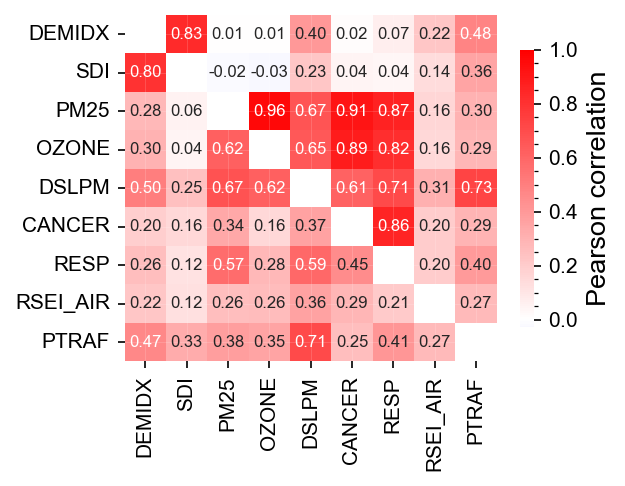

In [6]:
corr = []
for scale, func in [('Tract', np.triu), ('BG', np.tril)]:
    df = U.filt(ejs, scale=scale).drop(columns='geoid')
    df = df.rename(columns=str.upper)
    corr += [Pdf(func(df.corr()), columns=df.columns, index=df.columns)]
corr = corr[0] + corr[1]
np.fill_diagonal(corr.values, np.nan)
ax = U.plot(size=(4, 3), dpi=150, gridcolor='w')
sns.heatmap(corr, ax=ax, cmap='bwr', center=0, vmax=1,
            annot=True, fmt='.2f', annot_kws=D(size=8),
            cbar_kws=D(shrink=0.8, label='Pearson correlation'))
U.plot(ax, xlab='', ylab='', xminor=0, yminor=0)
U.imsave('Correlation of EJS variables')

# 4. Analyze

## 4.1. EJ vs SES

In [7]:
acs = pd.read_parquet(DATA / 'ses/acs/acs_2021.parquet').disp()

322,202 rows x 26 cols; Memory: 98.5 MiB


,geoid,scale,popu,house,labor,pop_density,house_density,p_minor,p_poc,p_loweng,...,p_disabled,p_snglparent,p_crowded,p_renter,p_mobilehome,p_noveh,m_hhperveh,p_nowfh,p_transit,p_walkbike
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,...,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,01001,County,58239.0,57692.0,27550.0,97.970679,97.050506,0.18,0.248699,0.002312,...,0.344985,0.231925,0.014733,0.233811,0.111367,0.054081,0.7189,0.952604,0.005713,0.009721


In [17]:
health = pd.read_parquet(DATA / 'health/health.parquet').disp()

1,788 rows x 10 cols; Memory: 0.3 MiB


,geoid,scale,health,asthma,cancer,copd,disabl,risk,insur,prevent
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,18001,County,0.217929,0.110429,0.072714,0.097714,0.326857,0.282476,0.103143,0.644625


In [21]:
acs.columns

Index(['geoid', 'scale', 'popu', 'house', 'labor', 'pop_density',
       'house_density', 'p_minor', 'p_senior', 'p_poc', 'p_lowedu', 'm_income',
       'p_pov', 'p_pov150', 'p_snap', 'p_unemploy', 'p_noinsur', 'p_disabled',
       'p_lowenglish', 'p_snglparent', 'p_crowded', 'p_renter', 'p_mobilehome',
       'p_noveh', 'm_hhperveh', 'p_nowfh', 'p_altmode'],
      dtype='object')

In [47]:
data = (health.merge(acs, on='geoid').merge(ejs, on='geoid').set_index('geoid')
        [['asthma', 'copd', 'p_poc', 'p_senior', 'p_pov', 'p_renter', 'm_hhperveh',
          'p_noveh', 'ptraf', 'resp', 'dslpm']]).disp()

1,779 rows x 11 cols; Memory: 0.2 MiB


,asthma,copd,p_poc,p_senior,p_pov,p_renter,m_hhperveh,p_noveh,ptraf,resp,dslpm
geoid,<float64>,<float64>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
18001,0.110429,0.097714,0.047527,0.150708,0.153265,0.133364,0.532966,0.127453,0.51087,0.413043,0.5


In [35]:
sem.inspector.inspect

<function semopy.inspector.inspect(model, mode='list', what='est', information='expected', std_est=False, se_robust=False)>

In [37]:
def sem_model(formula, data, identifier):
    model = sem.Model(formula)
    model.load_dataset(data)
    opt = sem.optimizer.Optimizer(model)
    opt.optimize()
    params = sem.inspector.inspect(opt)
    params.insert(0, 'case', identifier)
    return params

In [50]:
formula = '\n'.join([
    'pol =~ ptraf + resp + dslpm',
    'health =~ asthma + copd',
    'sed =~ p_pov + p_poc + p_renter + p_noveh',
    'pol ~ sed',
    'health ~ pol + sed'
]); # print(formula)

In [52]:
formula = '\n'.join([
    'pol =~ ptraf + resp + dslpm',
    'health =~ asthma + copd',
    'sed =~ p_pov + p_poc + p_renter',
    'p_noveh ~ sed',
    'pol ~ p_noveh',
    'health ~ pol + sed'
]); # print(formula)

In [53]:
model = sem.Model(formula)
model.load_dataset(data)
opt = sem.optimizer.Optimizer(model)
opt.optimize()
params = sem.inspector.inspect(opt)
params

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,p_noveh,~,sed,5.000497e-01,0.017039,29.347364,0.0
1,pol,~,p_noveh,4.321057e-01,0.067574,6.394591,0.0
2,health,~,pol,1.110690e-02,0.002949,3.76669,0.000165
3,health,~,sed,1.258773e-01,0.006988,18.014465,0.0
4,ptraf,~,pol,1.000000e+00,-,-,-
5,resp,~,pol,9.605387e-01,0.030148,31.860307,0.0
6,dslpm,~,pol,1.350175e+00,0.039748,33.968107,0.0
7,asthma,~,health,1.000000e+00,-,-,-
8,copd,~,health,8.857581e-01,0.031898,27.768459,0.0
9,p_pov,~,sed,1.000000e+00,-,-,-


In [58]:
zIndy = U.filt(zones, urba='Indianapolis, IN').disp()

1,549 rows x 7 cols; Memory: 0.5 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,county,cbsa,urba,aland,geometry
,<object>,<object>,<object>,<object>,<object>,<float32>,<geometry>
223,18011810601,Tract,Boone,Indianapolis-Carmel-Greenwood,"Indianapolis, IN",44.070984,"POLYGON ((-9617841.032804 4862739.27712, -9617..."


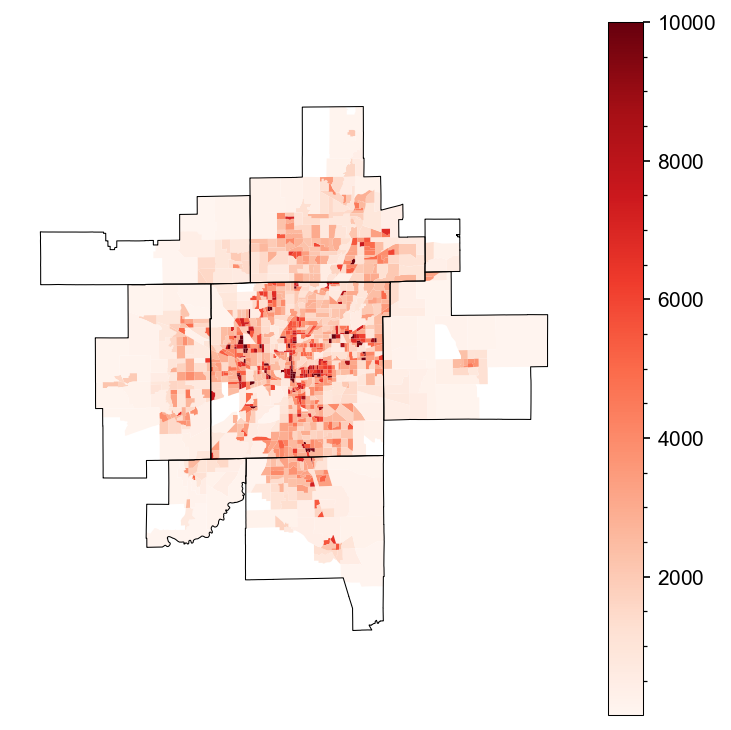

In [61]:
ax = U.plot(size=(6, 12), axoff=1)
zIndy.query('scale=="BG"').merge(acs).plot(ax=ax, cmap='Reds', vmax=10_000, column='pop_density', legend=True, legend_kwds=D(shrink=0.5))
zIndy.dissolve('county').plot(ax=ax, fc='none', ec='k', lw=0.5);

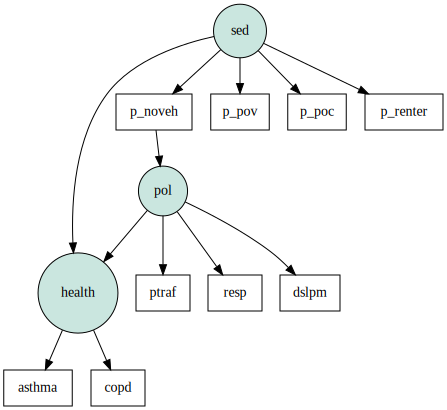

In [54]:
sem.semplot(model, 'test-sem.png', plot_covs=True)

In [46]:
hpms = (pd.read_parquet('/home/umni2/a/umnilab/users/verma99/mk/od_forecast/data/hpms/hpms2016.parquet',
        filters=[('state_code', '==', 37)])).disp() # 30s

568,346 rows x 91 cols; Memory: 1547.2 MiB


,state_code,route_id,national_route_id,begin_point,end_point,aadt,aadt_combination,aadt_single_unit,access_control,at_grade_other,...,urban_code,widening_obstacle,widening_potential,expansion_factor,year_last_construction,year_last_improv,sample_id,is_sample,length,geometry
,<int32>,<category>,<category>,<float64>,<float64>,<int32>,<int32>,<int32>,<int16>,<float64>,...,<int32>,<object>,<int16>,<float64>,<datetime64[ms]>,<datetime64[ms]>,<object>,<bool>,<float64>,<object>
0,37,40402000092,37_40402000092,0.227,12.09,0,0,0,0,NaN,...,0,,0,NaN,NaN,NaN,,False,2.101638,b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...


In [43]:
hpms.columns

Index(['state_code', 'route_id', 'national_route_id', 'begin_point',
       'end_point', 'aadt', 'aadt_combination', 'aadt_single_unit',
       'access_control', 'at_grade_other', 'base_thickness', 'base_type',
       'counter_peak_lanes', 'county_code', 'cracking_percent', 'curves_a',
       'curves_b', 'curves_c', 'curves_d', 'curves_e', 'curves_f',
       'dir_factor', 'f_system', 'facility_type', 'faulting', 'future_aadt',
       'future_aadt_year', 'future_facility', 'future_facility_year',
       'grades_a', 'grades_b', 'grades_c', 'grades_d', 'grades_e', 'grades_f',
       'hov_lanes', 'hov_type', 'iri', 'iri_year', 'k_factor', 'lane_width',
       'last_overlay_thickness', 'median_type', 'median_width', 'nhs',
       'nhs_year', 'number_signals', 'ownership', 'pct_green_time',
       'pct_pass_sight', 'pct_peak_combination', 'pct_peak_single',
       'peak_capacity', 'peak_lanes', 'peak_parking', 'psr', 'route_number',
       'route_name', 'route_qualifier', 'route_signing', 'r